# This notebook create zonal annual temperature plot for data-model-comparison

Recons points use 30 deg bands averaged annual temperature recons data calculated from Darrell's reconstruction dataset


## General setups

In [1]:
#import packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy
import regionmask

In [2]:
#Define model groups
pmip_v4='PMIP4'
pmip_v3='PMIP3'
pmip={}
pmip['PMIP4']=['AWI-CM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
               
  




In [3]:
#No change needs here

'''Define calculating functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../DATA" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../DATA/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../DATA/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

#This function will list excat model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict


#This function will find an regird avaiable models, calculate changes, regrid to 1x1 grids, and return model data
def ensemble_diffence(pmip_v):
    model_list=[]
    dataset={}
    model=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                dataset[gcm]=diff_1x1
                model.append(gcm)
    f3='model_lists/%s_%s_%s_zonal_modellist.csv' %(experiment_name,variable_name,pmip_v)
    modellist=pd.DataFrame(model_list)
    modellist.to_csv(f3)
    return dataset,model

#This function will create 1x1 grid MAT for all models in piControl 
def ensemble_pi_mean(pmip_v):
    model_list=[]
    dataset={}
    model=[]
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360., 1.0))})
    for gcm in B_dict:
        if gcm in pmip[pmip_v]:
            model_list.append(gcm)
            expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
            expt_b=expt_b_file[variable_name]
            this_regridder=xe.Regridder(expt_b_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            diff_1x1=this_regridder(expt_b)
            dataset[gcm]=diff_1x1
            model.append(gcm)
    f3='model_lists/pi_%s_%s_zonal_modellist.csv' %(variable_name,pmip_v)
    modellist=pd.DataFrame(model_list)
    modellist.to_csv(f3)
    return dataset,model


## Znoal averaged mat bands

In [4]:
#20 deg bands
#x=np.arange(0,181,20)
#30 deg bands
x=np.arange(0,181,30)
#This function will calculate zonal mean changes of every 30 deg in latitude for single PMIP generation
def zonal_mean(pmip_v):
    ensemble_diff_v,model_diff_v=ensemble_diffence(pmip_v)
    data={}
    for m in model_diff_v:
        data[m]=[]
        for i in range(len(x)-1):
            men=ensemble_diff_v[m][x[i]:x[i+1]]
            xx=np.average(men)
            data[m].append(xx)
    return data
#This function will calculate zonal mean cahnges of every 30 deg in latitude for both PMIP generations
def zonal_new():    
    ensemble_diff_v4,model_diff_v4=ensemble_diffence(pmip_v4)
    data4={}
    for m in model_diff_v4:
        data4[m]=[]
        for i in range(len(x)-1):
            men=ensemble_diff_v4[m][x[i]:x[i+1]]
            xx=np.average(men)
            data4[m].append(xx)
    ensemble_diff_v3,model_diff_v3=ensemble_diffence(pmip_v3)
    data3={}
    for m in model_diff_v3:
        data3[m]=[]
        for i in range(len(x)-1):
            men=ensemble_diff_v3[m][x[i]:x[i+1]]
            xx=np.average(men)
            data3[m].append(xx)
    return data3,model_diff_v3,data4,model_diff_v4

#This function will calculate zonal means of every 30 deg in latitude bands in piControl for both PMIP generations
def zonal_pi_new():    
    ensemble_pi_v4,model_pi_v4=ensemble_pi_mean(pmip_v4)
    data4={}
    for m in model_pi_v4:
        data4[m]=[]
        for i in range(len(x)-1):
            men=ensemble_pi_v4[m][x[i]:x[i+1]]
            xx=np.average(men)
            data4[m].append(xx)
    ensemble_pi_v3,model_pi_v3=ensemble_pi_mean(pmip_v3)
    data3={}
    for m in model_pi_v3:
        data3[m]=[]
        for i in range(len(x)-1):
            men=ensemble_pi_v3[m][x[i]:x[i+1]]
            xx=np.average(men)
            data3[m].append(xx)
    return data3,model_pi_v3,data4,model_pi_v4





    

## Plotting

In [5]:
#20 deg bands
#xla=['-90 ~ -70','-70 ~ -50','-50 ~ -30','-30 ~ -10','-10 ~ 10','10 ~ 30','30 ~ 50','50 ~ 70','70 ~ 90']
#30 deg bands
xla=['-90 ~ -60','-60 ~ -30','-30 ~ 0','0 ~ 30','30 ~ 60','60 ~ 90']
colorst =['firebrick','yellowgreen','plum','lightslategray','orange','springgreen','deepskyblue','peru','orchid','darkolivegreen','slateblue','mediumturquoise']

#zonal recons data
recons_zonal=[0.067,0.171,0.237,0.117,0.385,0.445]
yerr=[0.244,0.384,0.179,0.208,0.139,0.218]
#zonal obs data
obs_zonal=[-18.2817,10.0814,23.6106,24.7649,8.90803,-10.6966]
yerr_obs=[0.412207,0.100066,0.112806,0.127979,0.120554,0.300003]


def zonal_plot(pmip_v):
    ensemble_diff_v,model_diff_v=ensemble_diffence(pmip_v)
    data={}
    for m in model_diff_v:
        data[m]=[]
        for i in range(len(x)-1):
            men=ensemble_diff_v[m][x[i]:x[i+1]]
            xx=np.average(men)
            data[m].append(xx)
    plt.figure(figsize=(10,10))
    plt.axvline(x=0,color='k',linestyle="--")
    for i,m in enumerate(model_diff_v4):
        plt.scatter(data4[m],p1,color=colorst[i],marker='o',s=100,label=m)
    plt.errorbar(recons_zonal, xla, xerr=yerr,marker='o',color='k',ms=10,ls='none',label='Reconstruction')
    plt.legend()
    y_label='latitude (%sN)' %(chr(176))
    x_label='%sMAT (%sC)' %(chr(916),chr(176))
    plt.ylabel(y_label,fontsize=20)
    plt.xlabel(x_label,fontsize=20)
    figname='figs/%s_%s_zonal.png' %(experiment_name,variable_name)
    plt.savefig(figname)



def zonal_plot_pmip34():
    data3,model_diff_v3,data4,model_diff_v4=zonal_new()
    recons_zonal=[0.067,0.171,0.237,0.117,0.385,0.445]
    yerr=[0.244,0.384,0.179,0.208,0.139,0.218]
    p1=[1.1,2.1,3.1,4.1,5.1,6.1]
    p2=[0.9,1.9,2.9,3.9,4.9,5.9]
    p3=[1,2,3,4,5,6]
    plt.figure(figsize=(10,10))
    plt.ylim((0.5,6.5))
    plt.axvline(x=0,color='k',linestyle="--")
    for i,m in enumerate(model_diff_v4):
        plt.scatter(data4[m],p1,color=colorst[i],marker='o',s=100,label=m)
    for m in model_diff_v3:
        plt.plot(data3[m],p2,marker='o',fillstyle='none',mew=1.5, ms=6,linestyle='None',color='darkblue')
    plt.plot(data3[model_diff_v3[0]][0],p2[0],marker='o',fillstyle='none',mew=1.5, ms=6,linestyle='None',color='darkblue',label='PMIP3')
    plt.errorbar(recons_zonal, p1, xerr=yerr,marker='o',color='k',ms=10,ls='none',label='Reconstruction')
    plt.legend()
    plt.yticks(p3,xla,fontsize=10)
    y_label='latitude (%sN)' %(chr(176))
    x_label='%sMAT (%sC)' %(chr(916),chr(176))
    plt.ylabel(y_label,fontsize=20)
    plt.xlabel(x_label,fontsize=20)
    figname='figs/%s_%s_zonal_pmip3&4.png' %(experiment_name,variable_name)
    plt.savefig(figname)

#land only
def landmask():
    from global_land_mask import globe
    lat=np.arange(-89.5, 90., 1.0)
    lon=np.arange(-179.5, 180, 1.0)

    # Make a grid
    lon_grid, lat_grid = np.meshgrid(lon,lat)

    # Get whether the points are on land.
    z = globe.is_land(lat_grid, lon_grid)

    mask2=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            mask2[r][c]=z[r][c-180]  
    return mask2

def zonal_plot_lndonly(pmip_v):
    recons_zonal=[0.067,0.171,0.237,0.117,0.385,0.445]
    yerr=[0.244,0.384,0.179,0.208,0.139,0.218]
    ensemble_diff_v,model_diff_v=ensemble_diffence(pmip_v)
    mask2=landmask()
    data={}
    for m in model_diff_v:
        data[m]=[]
        for i in range(len(x)-1):
            ensemble_diff_v1=ensemble_diff_v[m].where(mask2)
            men=ensemble_diff_v1[x[i]:x[i+1]]
            xx=np.nanmean(men)
            data[m].append(xx)
    plt.figure(figsize=(10,10))
    plt.axvline(x=0,color='k',linestyle="--")
    for m in model_diff_v:
        plt.scatter(data[m],xla,marker='o',s=100,label=m)
    plt.errorbar(recons_zonal, xla, xerr=yerr,marker='o',color='k',ms=10,ls='none',label='Reconstruction')
    plt.legend()
    y_label='latitude (%sN)' %(chr(176))
    x_label='%sMAT (%sC)' %(chr(916),chr(176))
    plt.ylabel(y_label,fontsize=20)
    plt.xlabel(x_label,fontsize=20)
    figname='figs/%s_%s_zonal_lndonly.png' %(experiment_name,variable_name)
    plt.savefig(figname)


def zonal_plot_pi_pmip34():
    data3,model_pi_v3,data4,model_pi_v4=zonal_pi_new()
    
    p1=[1.2,2.2,3.2,4.2,5.2,6.2]
    p2=[0.8,1.8,2.8,3.8,4.8,5.8]
    p3=[1,2,3,4,5,6]
    
    plt.figure(figsize=(10,10))
    plt.ylim((0.5,6.5))
    plt.axvline(x=0,color='k',linestyle="--")
    for i,m in enumerate(model_pi_v4):
        plt.scatter(data4[m],p3,color=colorst[i],marker='o',s=100,label=m)
    for m in model_pi_v3:
        plt.plot(data3[m],p2,marker='o',fillstyle='none',mew=1.5, ms=6,linestyle='None',color='darkblue')
    plt.plot(data3[model_pi_v3[0]][0],p2[0],marker='o',fillstyle='none',mew=1.5, ms=6,linestyle='None',color='darkblue',label='PMIP3')
    #plt.scatter(recons_zonal, xla, marker='o',color='k',s=100,label='Reconstruction')
    plt.errorbar(obs_zonal, p1, xerr=yerr_obs,marker='s',ms=10,color='k',ls='none',label='Observation')
    plt.legend(loc=6)
    plt.yticks(p3,xla,fontsize=10)
    y_label='latitude (%sN)' %(chr(176))
    x_label='MAT (%sC)' %(chr(176))
    plt.ylabel(y_label,fontsize=20)
    plt.xlabel(x_label,fontsize=20)
    #plt.plot(0,)
    #plt.title(pmip_v)
    figname='figs/pi_%s_zonal_pmip3&4.png' %(variable_name)
    plt.savefig(figname)


# Figures

In [15]:
'''Set experiment and variable names'''
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'





Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_80x180_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_1

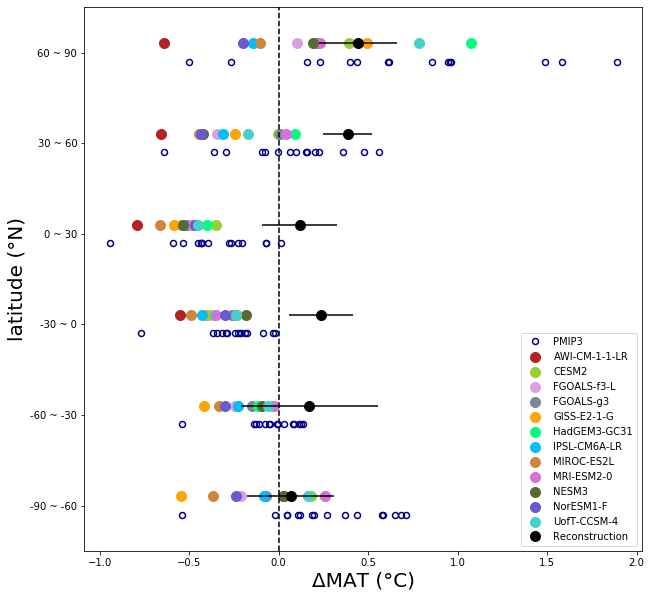

In [16]:
# zonal plot (all)
zonal_plot_pmip34()

/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'nino34_autocorrelation' has multiple fill values {-1073741800.0, 1e+30}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_80x180_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_1

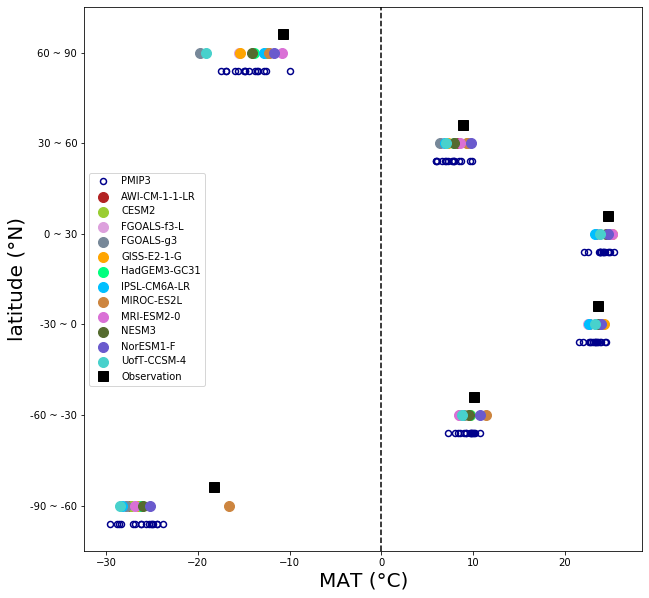

In [6]:
#piControl absolute mat vs obs
variable_name='tas_spatialmean_ann'
zonal_plot_pi_pmip34()